In [11]:
setwd('/import/DB/fel/BJTC-204')

In [12]:
exp<- read.table("./00_rawdata/exp.txt",sep = '\t',header = T,row.names = 1) 

In [13]:
length(unique(colnames(exp)))

[1] 161

In [14]:
dim(exp)

[1] 11845   161

In [15]:
#model.gene = rownames(exp)[1:50]

In [16]:
model.gene = c('RPE65' ,'DRD3', 'MC3R','RELB',  'PRF1')

In [17]:
data = as.data.frame(t(exp[model.gene,]))

In [18]:
library(readxl)

In [19]:
group = read_excel("./00_rawdata/DLPFC_group.xlsx")

In [20]:
library(dplyr)

Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [21]:
expr = data %>% as.data.frame() %>% 
tibble::rownames_to_column(.,'sample')

In [22]:
expr3 = merge(group,expr,by.x = 'Symbol',by.y = 'sample')

In [23]:
expr3[expr3$Group =='MDD',]$Group<-1
expr3[expr3$Group =='control',]$Group<-0
expr3$Group = as.numeric(expr3$Group)

In [24]:
expr3 = expr3[,-1]

In [25]:
fit.reduce<-glm(Group~RPE65 + DRD3+ MC3R+RELB  + PRF1 ,data=expr3,family=binomial())
summary(fit.reduce)


Call:
glm(formula = Group ~ RPE65 + DRD3 + MC3R + RELB + PRF1, family = binomial(), 
    data = expr3)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1009  -1.2207   0.6785   0.8175   1.2622  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  13.5174     9.4573   1.429    0.153
RPE65         2.6519     2.2095   1.200    0.230
DRD3         -3.1866     2.3896  -1.334    0.182
MC3R         -1.2185     1.6441  -0.741    0.459
RELB         -0.6897     0.9532  -0.724    0.469
PRF1          0.1467     1.2799   0.115    0.909

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 186.87  on 160  degrees of freedom
Residual deviance: 179.68  on 155  degrees of freedom
AIC: 191.68

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...

Loading required package: grid

Loading required package: checkmate

Warning message:
"package 'checkmate' was built under R version 4.2.3"
Loading required package: abind

Warning message:
"package 'abind' was built under R version 4.2.3"


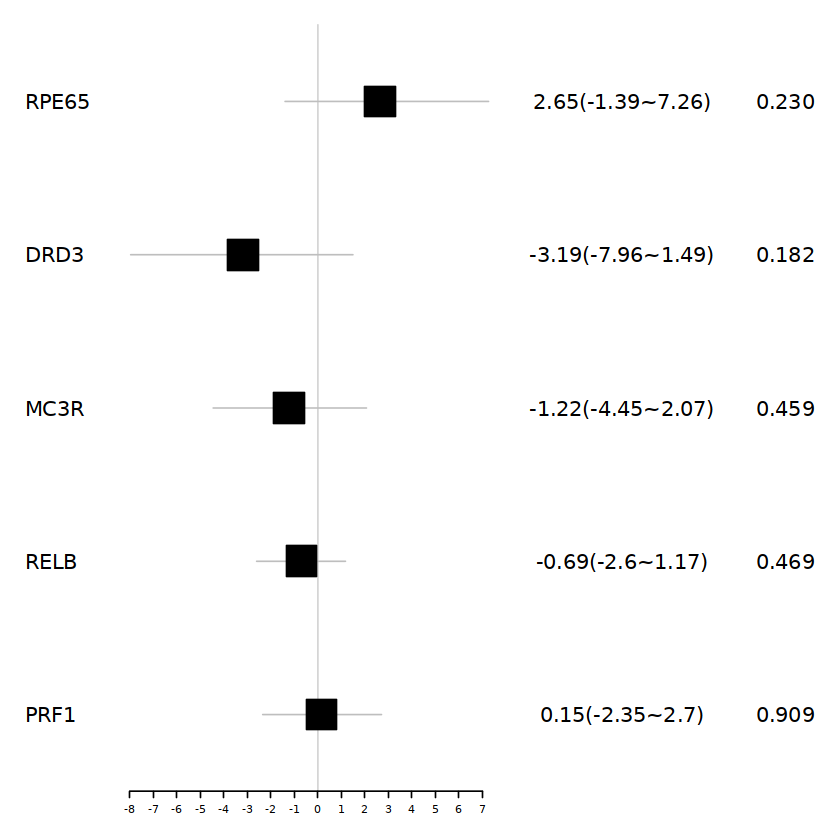

In [26]:
fit.result<-summary(fit.reduce)
df1<-fit.result$coefficients
df2<-confint(fit.reduce)
df3<-cbind(df1,df2)
df4<-data.frame(df3[-1,c(1,4,5,6)])
df4$Var<-rownames(df4)
colnames(df4)<-c("OR","Pvalue","OR_1","OR_2","Var")
df5<-df4[,c(5,1,2,3,4)]
df5$OR_mean<-df5$OR
df5$OR<-paste0(round(df5$OR,2),
               "(",
               round(df5$OR_1,2),
               "~",
               round(df5$OR_2,2),
               ")")
df5$Pvalue<-round(df5$Pvalue,3)
write.csv(df5,file = "forestplot_example2.csv",
          quote = F,row.names = F)

library(forestplot)
fp<-read.csv("forestplot_example2.csv",header=T)

forestplot(labeltext=as.matrix(fp[,1:3]),
           mean=fp$OR_mean,
           lower=fp$OR_1,
           upper=fp$OR_2,
           zero=0,
           boxsize=0.2,
           graph.pos=2)

In [41]:
expr3$group  = ifelse(expr3$Group == 0,'control','MDD')

In [42]:
head(expr3,2)

,Group,RPE65,DRD3,MC3R,RELB,PRF1,pred,group
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0,4.312566,4.668476,4.577139,6.014722,5.468890,0.7602406,control
2,1,4.327776,4.560743,4.642471,5.636162,5.388139,0.8464847,MDD


In [44]:
require(cowplot)
require(tidyverse)
require(ggplot2)
require(ggsci)
require(ggpubr)

Loading required package: cowplot

Warning message:
"package 'cowplot' was built under R version 4.2.3"
Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.1     v purrr   1.0.1
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.4     v forcats 1.0.0
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()    masks stats::filter()
x dplyr::lag()       masks stats::lag

In [45]:
mydata<-expr3 %>% 
  ## 基因表达数据gather,gather的范围应调整
  gather(key="gene",value="Expression",RPE65:PRF1) %>% 
  ##
  dplyr::select(group,gene,Expression) 

In [48]:
head(mydata,2)

,group,gene,Expression
,<chr>,<chr>,<dbl>
1,control,RPE65,4.312566
2,MDD,RPE65,4.327776


In [49]:


compare_means( Expression ~ group, data = mydata, method = 't.test',
              group.by = "gene")
# Box plot facetted by "gene"
p <- ggboxplot(mydata, x = "group", y = "Expression",
          color = "group", palette = "jco",
          add = "jitter",
          facet.by = "gene", short.panel.labs = FALSE)
# Use only p.format as label. Remove method name.
#p + stat_compare_means(label =  "p.signif", label.x = 1.5)
p <- ggboxplot(mydata, x = "gene", y = "Expression",
          color = "group", palette = "nejm",
          add = "jitter")

diffgene = as.data.frame(compare_means( Expression ~ group, data = mydata, method = 't.test',
              group.by = "gene"))

diffgene = rownames(diffgene) = diffgene[,1]

write.csv(diffgene,file = 'diffgene.test.161.sample.csv')

options(repr.plot.height = 5,repr.plot.width = 9)

gene,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
RPE65,Expression,control,MDD,0.92753823,1.00,0.928,ns,T-test
DRD3,Expression,control,MDD,0.02009522,0.10,0.020,*,T-test
MC3R,Expression,control,MDD,0.06700865,0.27,0.067,ns,T-test
RELB,Expression,control,MDD,0.15531530,0.47,0.155,ns,T-test
PRF1,Expression,control,MDD,0.54950888,1.00,0.550,ns,T-test


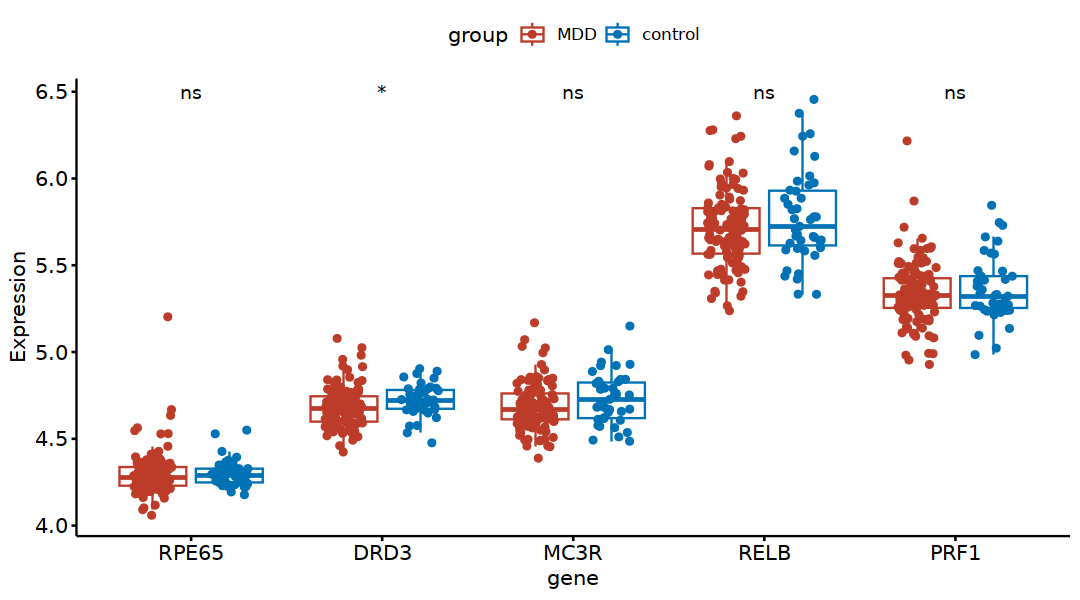

In [50]:
p + stat_compare_means(aes(group = group), label = "p.signif",method = 't.test')

In [27]:
summary(fit.reduce) #查看构建的模型
fitted.prob<-predict(fit.reduce, newdata = expr3, type = "response")  #这里不需要变动
expr3$pred<-fit.reduce$fitted.values
m<-pROC::roc(expr3$Group,expr3[,"pred"])  #这里要把Y改为自己的结局变量即可


Call:
glm(formula = Group ~ RPE65 + DRD3 + MC3R + RELB + PRF1, family = binomial(), 
    data = expr3)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1009  -1.2207   0.6785   0.8175   1.2622  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  13.5174     9.4573   1.429    0.153
RPE65         2.6519     2.2095   1.200    0.230
DRD3         -3.1866     2.3896  -1.334    0.182
MC3R         -1.2185     1.6441  -0.741    0.459
RELB         -0.6897     0.9532  -0.724    0.469
PRF1          0.1467     1.2799   0.115    0.909

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 186.87  on 160  degrees of freedom
Residual deviance: 179.68  on 155  degrees of freedom
AIC: 191.68

Number of Fisher Scoring iterations: 4


Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [28]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


Area under the curve: 0.6315

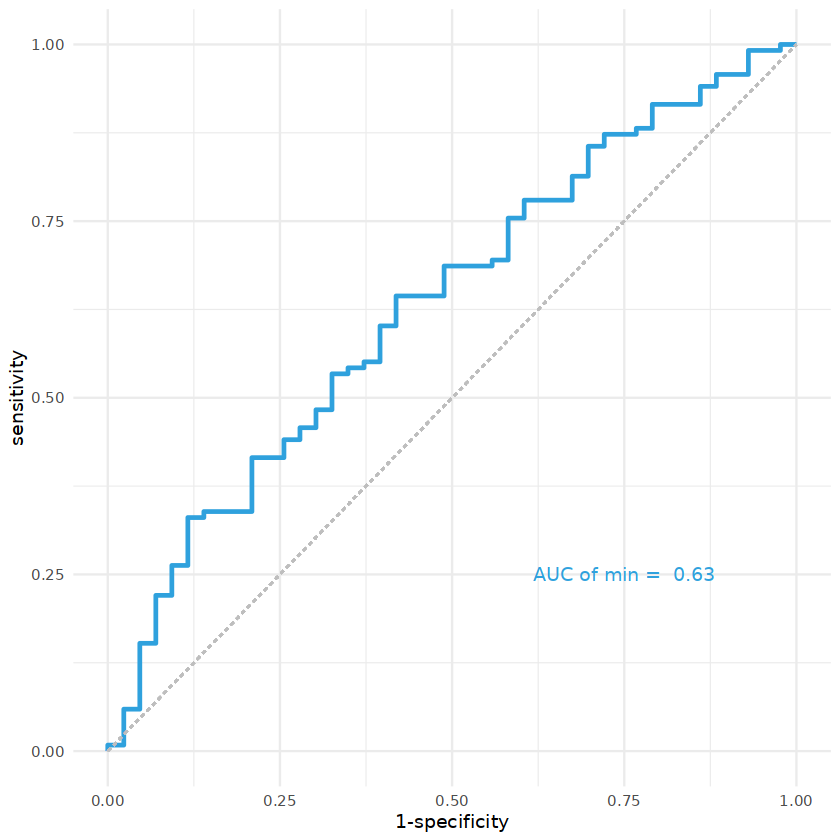

In [29]:
g <- pROC::ggroc(m,legacy.axes = T,size = 1,color = "#2fa1dd")
pROC::auc(m)  # Area under the curve: 0.9953

g + theme_minimal() +
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), 
               colour = "grey", linetype = "dashed")+
  annotate("text",x = .75, y = .25,
           label = paste("AUC of min = ",format(round(as.numeric(pROC::auc(m)),2),nsmall = 2)),color = "#2fa1dd")

In [30]:
library(ROCR)
library(rms)

Warning message:
"package 'ROCR' was built under R version 4.2.3"
Loading required package: Hmisc

Warning message:
"package 'Hmisc' was built under R version 4.2.3"

Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units




In [31]:
expr3$Group = as.factor(expr3$Group)

In [32]:
dd<-rms::datadist(expr3)  #开始打包数据
options(datadist="dd")

In [33]:
formula1<-as.formula(Group~. )  #RPE65 + MC3R+NFIL3 + PRF1 + IL6
fit1<-lrm(formula1,data = expr3,x=T,y=T)

In [34]:
# nom1 <- rms::nomogram(fit1, fun=plogis,
#                 #fun.at=c(0.001,0.1,0.25,0.5,0.75,0.9,0.99),
#                  #lp=T, # 是否显示线性概率
#                  funlabel="Risk of Death")  
# plot(nom1) 


In [35]:
mdd = group %>% dplyr::filter(Group == 'MDD') 

In [36]:
mdd.sample = mdd$Symbol

In [37]:
nmfinput = expr %>% dplyr::filter(sample %in%  mdd.sample)

In [38]:
dim(nmfinput)

[1] 118   6

In [31]:
length(unique(nmfinput$sample))

[1] 118

In [32]:
rownames(nmfinput) = nmfinput[,1]
nmfinput = as.data.frame(t(nmfinput[,-c(1)]))

In [33]:
library(NMF)

Loading required package: registry

Warning message:
"package 'registry' was built under R version 4.2.3"
Loading required package: rngtools

Warning message:
"package 'rngtools' was built under R version 4.2.3"
Loading required package: cluster

Warning message:
"package 'cluster' was built under R version 4.2.3"
NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')



In [34]:
ranks <- 1:10
estim.coad <- nmf(nmfinput,ranks, nrun=10)
duplicated(colnames(nmfinput))

Warning message in cor(d.consensus, d.coph, method = "pearson"):
"the standard deviation is zero"


[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

Warning message:
"Removed 4 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 7 rows containing missing values (`geom_point()`)."


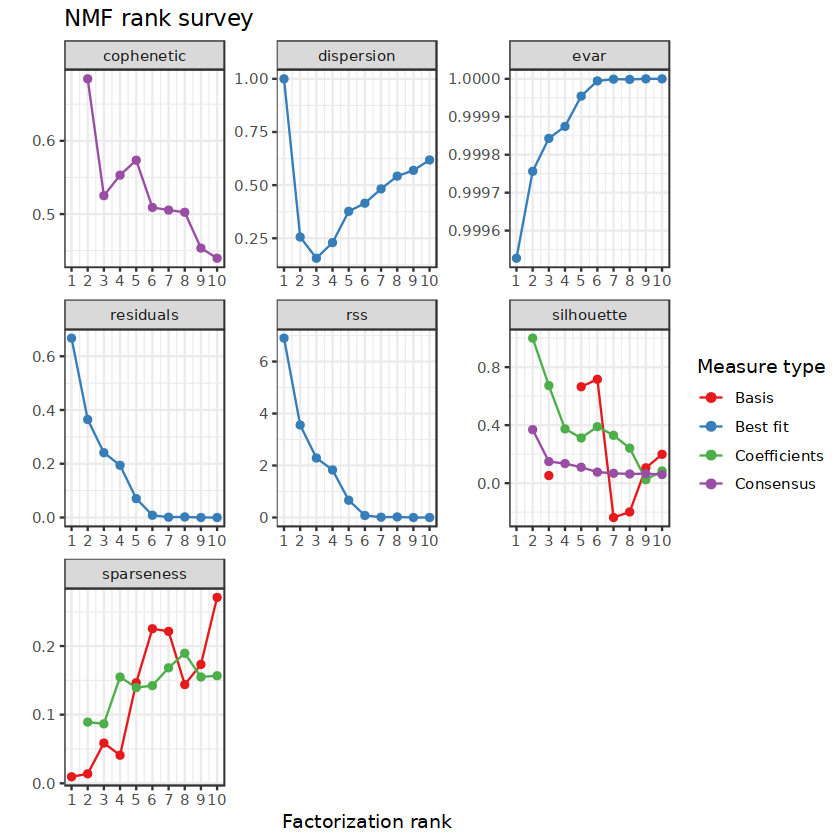

In [35]:
plot(estim.coad)

In [36]:
seed = 2020820
nmf.rank4 <- nmf(nmfinput, 
                 rank = 2, 
                 nrun=50,
                 seed = seed, 
                 method = "brunet")

group
 1  2 
48 70 

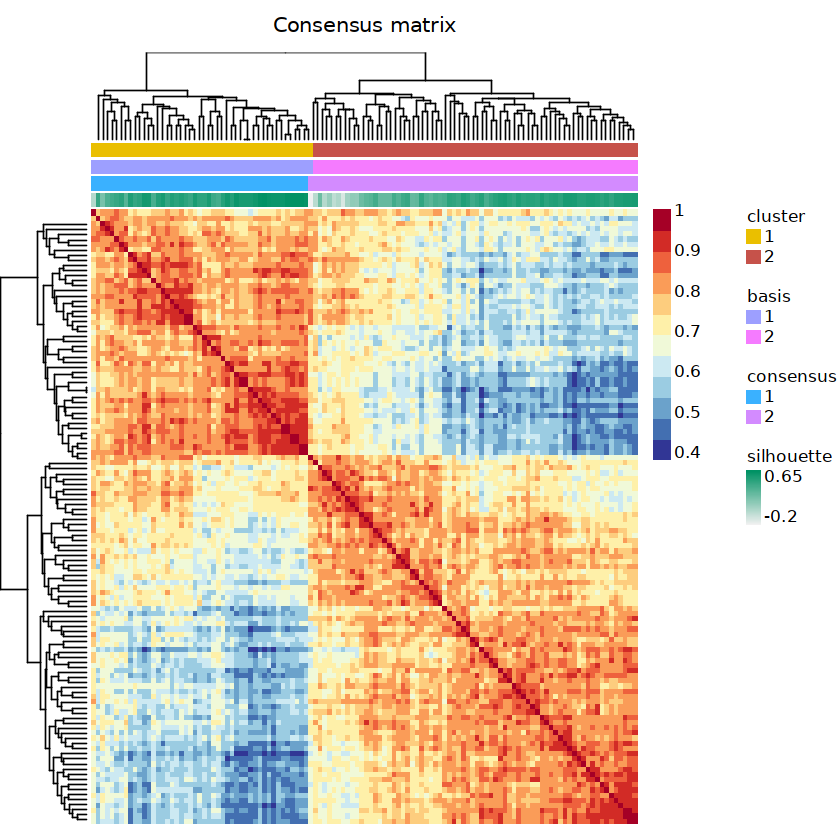

In [37]:
jco <- c("#EABF00","#C6524A","#868686")
index <- extractFeatures(nmf.rank4,"max") 
sig.order <- unlist(index)
NMF.Exp.rank4 <- nmfinput[sig.order,]
NMF.Exp.rank4 <- na.omit(NMF.Exp.rank4) #sig.order有时候会有缺失值
group <- predict(nmf.rank4) # 提出亚型
table(group)
consensusmap(nmf.rank4,
             labRow = NA,
             labCol = NA,
             annCol = data.frame("cluster"=group[colnames(NMF.Exp.rank4)]),
             annColors = list(cluster=c("1"=jco[1],"2"=jco[2])))

In [38]:
library(tinyarray)



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree




Attaching package: 'tinyarray'


The following object is masked from 'package:dplyr':

    union_all




In [39]:
dim(nmfinput)

[1]   5 118

In [40]:
a = exp[,colnames(nmfinput)]

In [41]:
cg=names(tail(sort(apply(a,1,sd)),12000))
n=a[cg,]

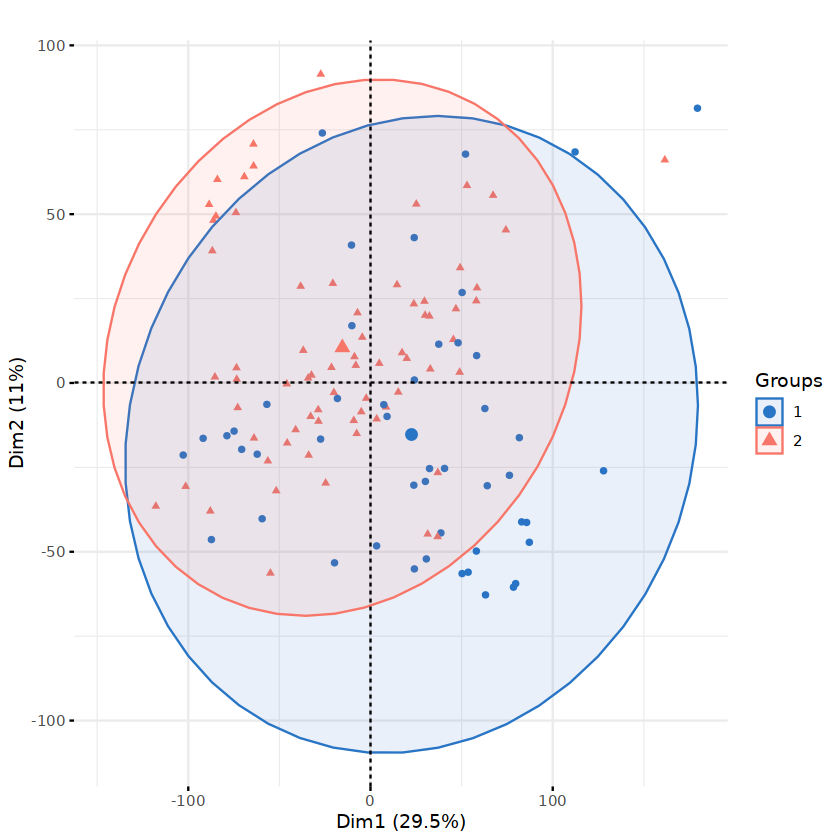

In [42]:
draw_pca(n,group)

In [43]:
library(Rtsne)
tsne_out = Rtsne(t(n),perplexity = 30)
pdat = data.frame(tsne_out$Y,factor(group))
colnames(pdat) = c("Y1","Y2","group")
head(pdat)

,Y1,Y2,group
,<dbl>,<dbl>,<fct>
GSM1124359,3.316984,0.2205414,2
GSM1124360,3.544263,-0.5172745,2
GSM1124361,2.846761,0.8478037,2
GSM1124362,3.204684,0.2963016,2
GSM1124363,2.247441,6.4482691,2
GSM1124364,3.461212,2.5267244,2


In [46]:
pdat1 = pdat %>% tibble::rownames_to_column(.,'sample')

In [47]:
bulk3.group = pdat1[,c(1,4)]

In [48]:
write.csv(bulk3.group,file = 'bulk.3.group.csv',row.names =F)

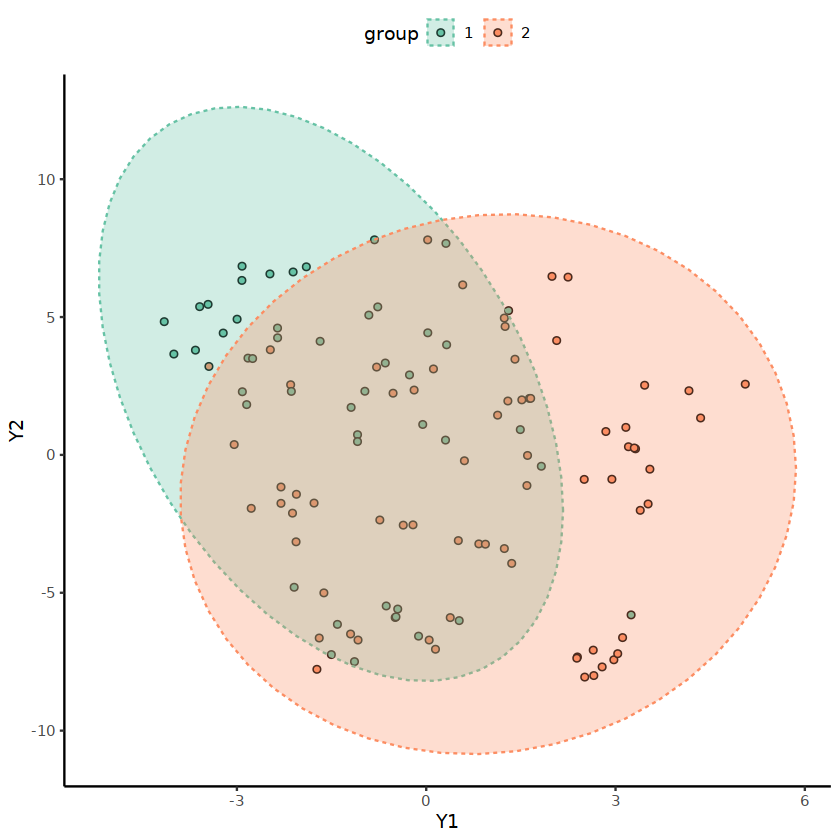

In [44]:
library(ggplot2)
library(paletteer)
ggplot(pdat,aes(Y1,Y2))+
  geom_point(aes(Y1,Y2,fill = group),shape = 21,color = "black")+
  stat_ellipse(aes(color = group,fill = group),
               geom = "polygon",
               alpha = 0.3,
               linetype = 2)+
  scale_color_paletteer_d("RColorBrewer::Set2")+
  scale_fill_paletteer_d("RColorBrewer::Set2")+
  theme_classic()+
  theme(legend.position = "top")

In [162]:
groupinfo = as.data.frame(group)

In [125]:
save(nmfinput,groupinfo,file = 'bulk2.rda')